In [1]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv(r'C:/Users/Jordan/Desktop/jupyter notebook/Info Retrieval/Salarys in sectors.csv')
df.shape

(2500, 8)

In [3]:
from io import StringIO
col = ['Sector', 'JobTitle']
df = df[col]
df = df[pd.notnull(df['JobTitle'])]
df.columns = ['Sector', 'JobTitle']
df['category_id'] = df['Sector'].factorize()[0]
category_id_df = df[['Sector', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Sector']].values)
df.head(25)

,Sector,JobTitle,category_id
0,Health,Social worker (embedded in primary care),0
1,Business,Copywriter,1
2,Business,Senior Consultant,1
3,Health,Project specialist,0
4,Health,Decision Support Analyst,0
5,Health,Account manager,0
6,Health,Social Worker,0
7,Health,Assciate,0
8,Health,Editor-in-Chief,0
9,Health,HR Consultant,0


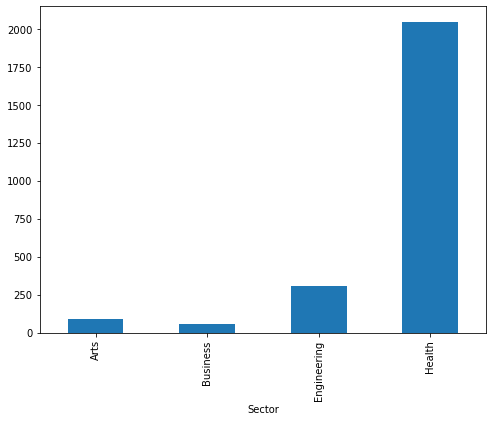

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Sector').JobTitle.count().plot.bar(ylim=0)
plt.show()

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.JobTitle).toarray()
labels = df.category_id
features.shape

(2500, 270)

In [6]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Sector, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("--> '{}':".format(Sector))
    print("  . Most Correlated Unigrams are :\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most Correlated Bigrams are :\n. {}".format('\n. '.join(bigrams[-N:])))

--> 'Arts':
  . Most Correlated Unigrams are :
. development
. programs
  . Most Correlated Bigrams are :
. assistant director
. executive director
--> 'Business':
  . Most Correlated Unigrams are :
. management
. bookkeeper
  . Most Correlated Bigrams are :
. director business
. program director
--> 'Engineering':
  . Most Correlated Unigrams are :
. mechanical
. engineer
  . Most Correlated Bigrams are :
. mechanical engineer
. project engineer
--> 'Health':
  . Most Correlated Unigrams are :
. mechanical
. engineer
  . Most Correlated Bigrams are :
. mechanical engineer
. project engineer


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['JobTitle'], df['Sector'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [8]:
print(clf.predict(count_vect.transform(['Mechanical'])))

['Engineering']


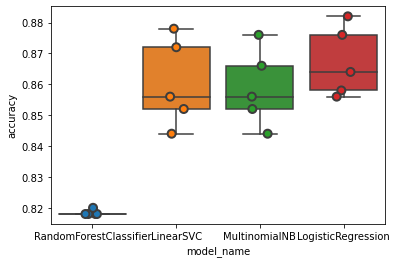

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [10]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.8604
LogisticRegression        0.8672
MultinomialNB             0.8588
RandomForestClassifier    0.8184
Name: accuracy, dtype: float64

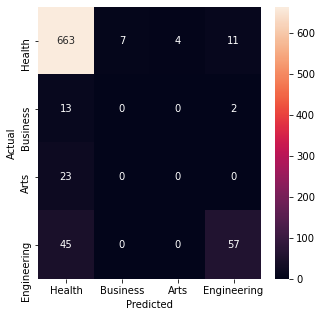

In [11]:
model1 = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Sector.values, yticklabels=category_id_df.Sector.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

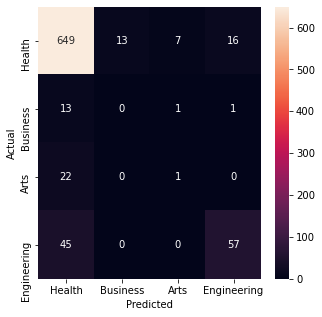

In [12]:
model2 = RandomForestClassifier()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Sector.values, yticklabels=category_id_df.Sector.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

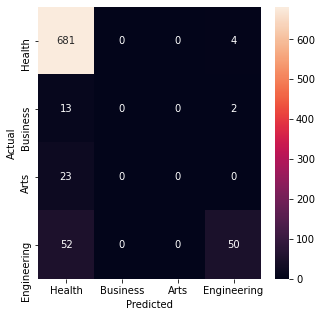

In [13]:
model3 = MultinomialNB()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Sector.values, yticklabels=category_id_df.Sector.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

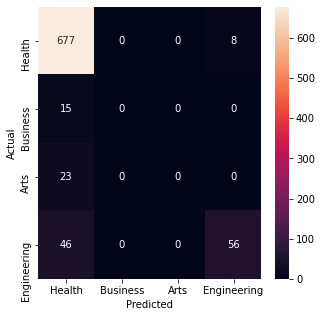

In [14]:
model4 = LogisticRegression()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model4.fit(X_train, y_train)
y_pred = model4.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Sector.values, yticklabels=category_id_df.Sector.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()